In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import shap
from matplotlib.lines import Line2D
from sklearn.cluster import DBSCAN
import scipy.stats as stats
# import dataset with portland from 2021
portland2021 = pd.read_csv('portland.csv', sep=',') 

In [103]:
#See available columns
portland2021.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Date', 'Year', 'Month', 'Day_of_Week',
       'Hour'],
      dtype='object')

*** DBSCAN ***

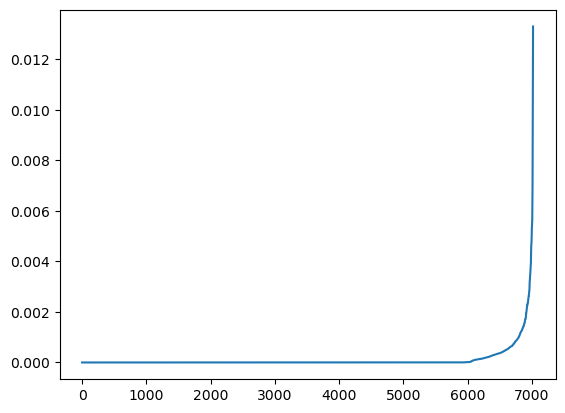

In [104]:
#Make dataframe with only latitude and longitude
latlng = portland2021[['Start_Lng', 'Start_Lat']]
#k-distance plot to find optimal eps
neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(latlng)
distances, indices = neighbors_fit.kneighbors(latlng)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

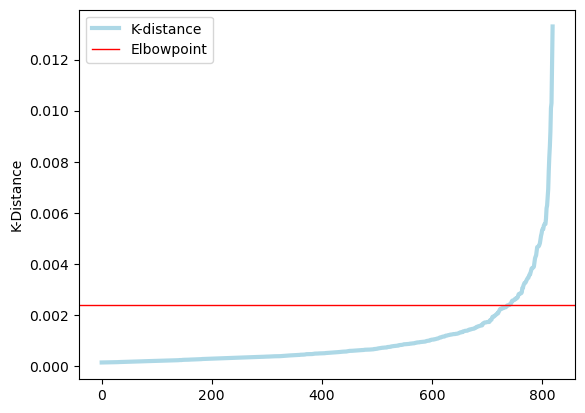

In [105]:
#zoom in on the elbowpoint
plt.plot(distances[6200:], linewidth=3.0, c='lightblue')
plt.axhline(y=0.00240, color='r', linewidth=1.0)
plt.ylabel('K-Distance')
plt.legend(['K-distance', 'Elbowpoint'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


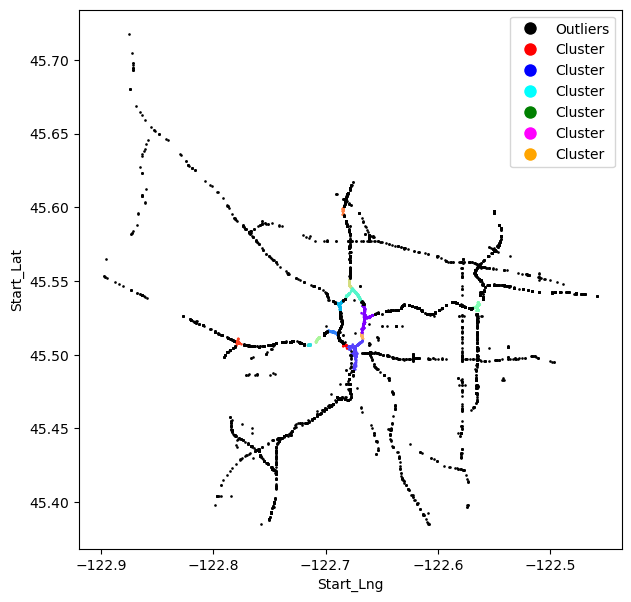

In [106]:

from matplotlib.lines import Line2D
dbscan = DBSCAN(eps=0.00235, min_samples=63).fit(latlng)
latlng['cluster_location'] = dbscan.labels_
#Make a seperate dataframe with only the outliers
outliers = latlng[latlng['cluster_location'] == -1]
#Make a seperate dataframe with only the clusters
clusters = latlng[latlng['cluster_location'] != -1]
#plot the clusters and outliers
fig, ax = plt.subplots()
ax.scatter(clusters['Start_Lng'], clusters['Start_Lat'], c=clusters['cluster_location'], cmap='rainbow', s=0.8, label='clusters')
ax.scatter(outliers['Start_Lng'], outliers['Start_Lat'], c='black', s=0.8, label='outliers' )
ax.set_xlabel('Start_Lng')
ax.set_ylabel('Start_Lat')
fig.set_size_inches(7,7)

#Add custom legend
legend_elements = [Line2D([0], [0], marker='o', color='white', label='Outliers',
                          markerfacecolor='black', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Cluster',
                          markerfacecolor='red', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Cluster',
                          markerfacecolor='blue', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Cluster',
                          markerfacecolor='cyan', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Cluster',
                          markerfacecolor='green', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Cluster',
                          markerfacecolor='magenta', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Cluster',
                          markerfacecolor='orange', markersize=10)     
                          ]
plt.legend(handles=legend_elements)
plt.show()

*** Feature engineering ***

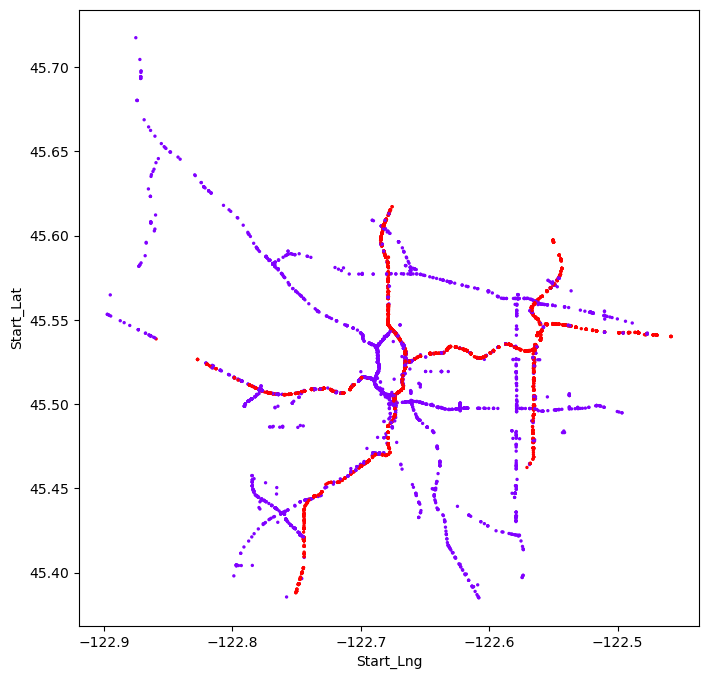

In [107]:
#make custom cmap
portland2021['StreetCats'] = np.where(portland2021['Street'].isin(portland2021['Street'].value_counts().head(7).index), 1, 0)
#scatter plot of Start_Lng and Start_Lat with color based on Street
fig, ax = plt.subplots()
scatter = ax.scatter(portland2021['Start_Lng'], portland2021['Start_Lat'], c=portland2021['StreetCats'], cmap='rainbow', s=2)
ax.set_xlabel('Start_Lng')
ax.set_ylabel('Start_Lat')
#make legend where 0 is small street and 1 is big street  
fig.set_size_inches(8, 8)

Text(0, 0.5, 'Number of accidents')

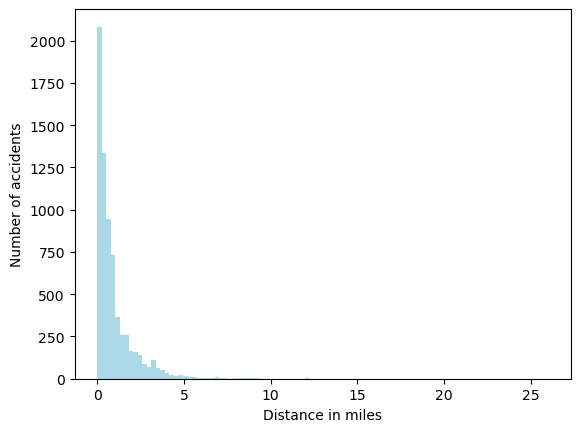

In [108]:
#Histogram of Distance(mi)
plt.hist(
    portland2021[portland2021['Distance(mi)'] < 30]['Distance(mi)'],
    bins=100,
    color='lightblue'
)

plt.xlabel('Distance in miles')
plt.ylabel('Number of accidents')


([], [])

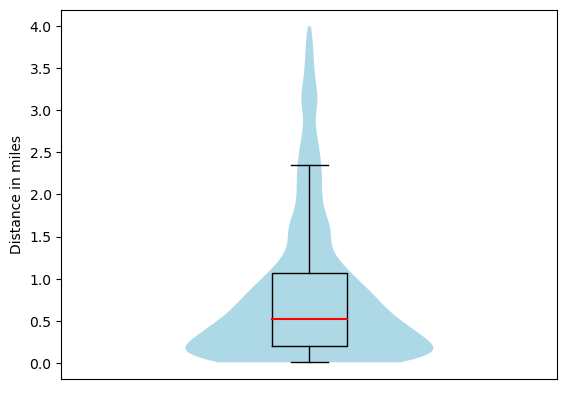

In [109]:
#Violin and boxplot of Distance(mi)
data = portland2021[portland2021['Distance(mi)'] < 4]['Distance(mi)']

parts = plt.violinplot(data, showmeans=False, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(1)

#remove the lavels on the x-axis
plt.ylabel('Distance in miles')
medianprops = dict(color="red",linewidth=1.5)
plt.boxplot(data, showfliers=False, medianprops=medianprops)
plt.xticks([])

In [110]:
#Engineer features to be useful
#time
portland2021['Date'] = pd.to_datetime(portland2021['Start_Time']).dt.date
portland2021['Year'] = pd.to_datetime(portland2021['Start_Time']).dt.year
portland2021['Month'] = pd.to_datetime(portland2021['Start_Time']).dt.month
portland2021['Day_of_Week'] = pd.to_datetime(portland2021['Start_Time']).dt.dayofweek
portland2021['Hour'] = pd.to_datetime(portland2021['Start_Time']).dt.hour

#categorize hours
def categorize(col):
    bins = np.linspace(0, 23, 5)
    return pd.cut(col, bins, labels=['Night','Morning','Afternoon','Evening'], include_lowest=True)

portland2021['hour_cat'] = categorize(portland2021['Hour'])

#visibility and weather
#We replace the missing values with the mean
portland2021['Visibility(mi)'].fillna(portland2021['Visibility(mi)'].mean(), inplace=True)

#We see that the data is skewed to the right. We can use the log transformation to make the data more normal. 
#Here we are using the natural log on each value in the visibility column.
portland2021['Visibility(mi)'] = np.log(portland2021['Visibility(mi)'])

#Remove values that are below or equal to 0 as negative visibility is not possible.
portland2021 = portland2021[portland2021['Visibility(mi)'] > 0]

# We aggregate weather conditions categories into 7 larger categories, specifically: Cloudy, Fair, Rain, Snow, Thunder, Fog and Wintry Mix

#Combine Cloudy, Mosty Cloudy, Partly Cloudy, Mostly Cloudy / Windy, Cloudy / Windy
portland2021['Weather_Condition'] = portland2021['Weather_Condition'].replace(['Cloudy', 'Mostly Cloudy', 'Mostly Cloudy / Windy', 'Cloudy / Windy'], 'Cloudy')
#Combine Fair, Fair / Windy, Partly Cloudy
portland2021['Weather_Condition'] = portland2021['Weather_Condition'].replace(['Fair', 'Fair / Windy', 'Partly Cloudy'], 'Fair')
#Combine Rain, Heavy Rain, Light Rain, Light Rain / Windy, Heavy Rain / Windy, Rain / Windy
portland2021['Weather_Condition'] = portland2021['Weather_Condition'].replace(['Rain', 'Heavy Rain', 'Light Rain', 'Light Rain / Windy', 'Heavy Rain / Windy', 'Rain / Windy', 'Light Freezing Drizzle', 'Light Drizzle'], 'Rain')
#Combine Snow, Light Snow, Light Snow / Windy, Snow / Windy, Light Snow and Sleet, Light Snow and Sleet / Windy
portland2021['Weather_Condition'] = portland2021['Weather_Condition'].replace(['Light Snow', 'Snow', 'Light Snow / Windy', 'Snow / Windy', 'Light Snow and Sleet', 'Light Snow and Sleet / Windy'], 'Snow')
#Combine Thunderstorm, Thunderstorm / Windy, Thunderstorm with Hail, Thunderstorm with Hail / Windy, Thunderstorm with Light Rain, Thunderstorm with Light Rain / Windy, Thunderstorm with Rain, Thunderstorm with Rain / Windy, T-Storm, T-Storm / Windy, T-Storm with Hail, T-Storm with Hail / Windy, T-Storm with Light Rain, T-Storm with Light Rain / Windy, T-Storm with Rain, T-Storm with Rain / Windy, Thunder in the Vicinity
portland2021['Weather_Condition'] = portland2021['Weather_Condition'].replace(['Thunderstorm', 'Thunderstorm / Windy', 'Thunderstorm with Hail', 'Thunderstorm with Hail / Windy', 'Thunderstorm with Light Rain', 'Thunderstorm with Light Rain / Windy', 'Thunderstorm with Rain', 'Thunderstorm with Rain / Windy', 'T-Storm', 'T-Storm / Windy', 'T-Storm with Hail', 'T-Storm with Hail / Windy', 'T-Storm with Light Rain', 'T-Storm with Light Rain / Windy', 'T-Storm with Rain', 'T-Storm with Rain / Windy', 'Thunder in the Vicinity'], 'Thunder')
#Combine Fog, Fog / Windy, Hazey, Haze, Haze / Windy, Smoke, Smoke / Windy
portland2021['Weather_Condition'] = portland2021['Weather_Condition'].replace(['Fog', 'Fog / Windy', 'Haze', 'Haze / Windy', 'Smoke', 'Smoke / Windy', 'Mist', 'Shallow Fog', 'Patches of Fog'], 'Fog')
#Combine wintry mix, wintry mix / windy, sleet, sleet / windy, freezing rain, freezing rain / windy, freezing drizzle, freezing drizzle / windy, light freezing rain, light freezing rain / windy, light freezing drizzle, light freezing drizzle / windy
portland2021['Weather_Condition'] = portland2021['Weather_Condition'].replace(['Wintry Mix', 'Wintry Mix / Windy', 'Sleet', 'Sleet / Windy', 'Freezing Rain', 'Freezing Rain / Windy', 'Freezing Drizzle', 'Freezing Drizzle / Windy', 'Light Freezing Rain', 'Light Freezing Rain / Windy', 'Light Freezing Drizzle', 'Light Freezing Drizzle / Windy'], 'Wintry Mix')

# We remove the rows with Weather_Condition = N/A Precipitation
portland2021 = portland2021[portland2021['Weather_Condition'] != 'N/A Precipitation']

# We one hot encode Weather_Condition
portland2021 = pd.get_dummies(portland2021, columns=['Weather_Condition'], prefix = ['Weather_Condition'])



In [111]:
#Edit binary columns
#We have missing values in the 'Sunrise_Sunset' column, that we replace with the most fequent value
portland2021['Sunrise_Sunset'].fillna(portland2021['Sunrise_Sunset'].mode()[0], inplace=True)
#Binary encode Sunrise_Sunset, Traffic_Calming, Crossing and Junction
portland2021['Sunrise_Sunset'] = portland2021['Sunrise_Sunset'].replace(['Day', 'Night'], [1, 0])
portland2021['Traffic_Calming'] = portland2021['Traffic_Calming'].replace([False, True], [0, 1])
portland2021['Crossing'] = portland2021['Crossing'].replace([False, True], [0, 1])
portland2021['Junction'] = portland2021['Junction'].replace([False, True], [0, 1])


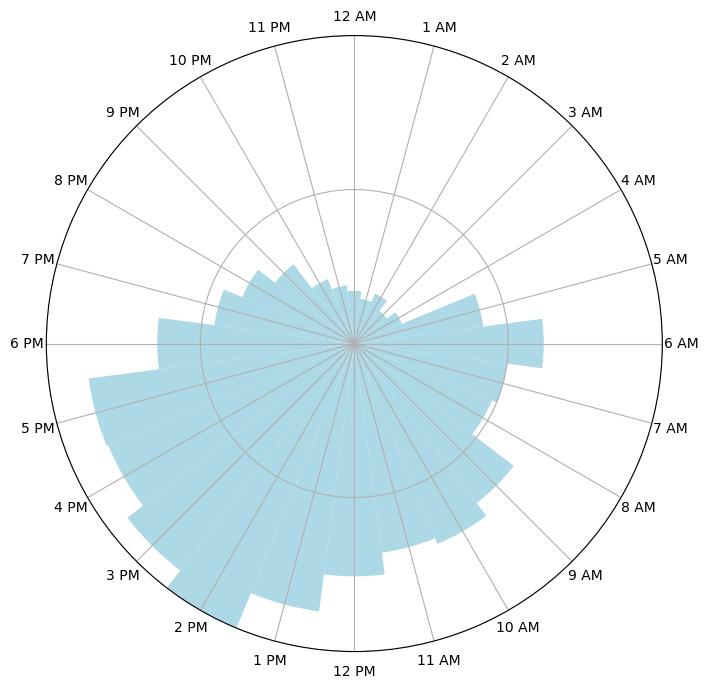

In [116]:
#Make clock-plot (a bit out of place)
a = portland2021['Hour'].value_counts().sort_index()
#select highest count from a
max = a.max()

N = 24
bottom = 2

theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii, tick = np.histogram(portland2021['Hour'], bins=24)
width = (2*np.pi) / N

plt.figure(figsize = (12, 8))
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom, alpha=1, color='lightblue')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
ticks = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM','8 AM','9 AM','10 AM','11 AM','12 PM', '1 PM', '2 PM', '3 PM', '4 PM',  '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM' ]
ax.set_xticklabels(ticks)
plt.setp(ax.get_yticklabels(), visible=False)
plt.ylim(0,max)
ax.set_rticks([max/2,max])
plt.show()

(-0.3, 1.0)

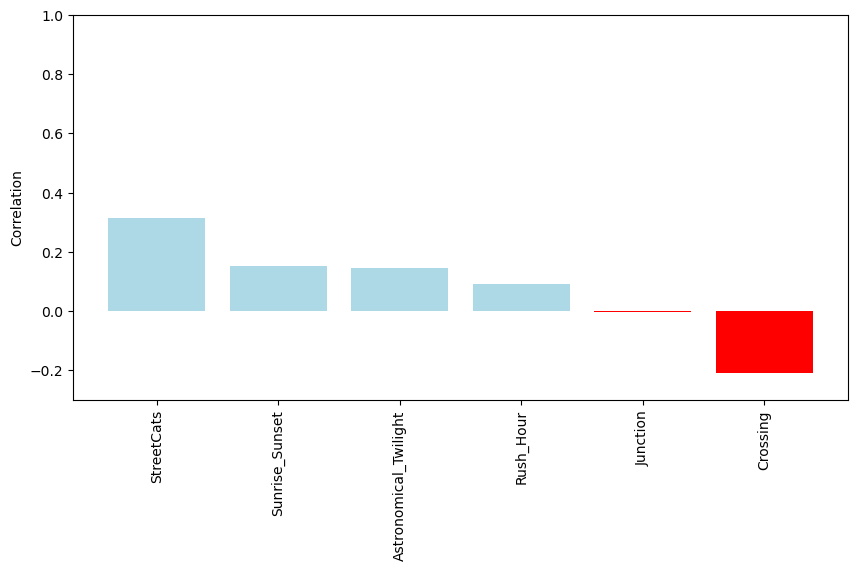

In [114]:
#Check correlation between binary columns and Distance(mi)

#Add new category 'RushHour' to convert hour to binary for the sole purpose of checking correlation
portland2021['Rush_Hour'] = np.where(portland2021['Hour'].isin([8,9,10,11,12,13,14,15,16,17]), 1, 0)
#Add Astronomy Twilight and convert to binary
portland2021['Astronomical_Twilight'] = portland2021['Astronomical_Twilight'].replace(['Day', 'Night'], [1, 0])
#Select binary columns

df = portland2021[['Distance(mi)', 'Sunrise_Sunset', 'Crossing','Junction','StreetCats','Astronomical_Twilight', 'Rush_Hour']]
#Select only rows with Distance(mi) <= 5
df = df[df['Distance(mi)'] <= 5]

#Calculate correlation with point-biserial correlation between the categories and Distance(mi)

corr = []

for col in df.columns:
    correlation, pvalue = stats.pearsonr(df[col], df['Distance(mi)'])
    corr.append((col,correlation,pvalue))

#plot corr
corr = pd.DataFrame(corr, columns=['Feature', 'Correlation', 'P-value'])
corr = corr[['Feature', 'Correlation']]
#drop columnn where Feature is Distance(mi)
corr = corr[corr['Feature'] != 'Distance(mi)']
corr = corr.sort_values(by='Correlation', ascending=False)
plt.figure(figsize=(10,5))
plt.bar(corr['Feature'], corr['Correlation'], color=['lightblue' if x > 0 else 'red' for x in corr['Correlation']])
plt.xticks(rotation=90)
plt.ylabel('Correlation')
plt.ylim(-0.3, 1)

